# TTE_R_TO_PYTHON

- Zeus Elderfield
- Earl Rondina

## Instructions: 

Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is 2 weeks from today: February 28, 2025 at 11:59 pm.

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.

# Target Trial Emulation: Translating R Code to Python

### Overview
The provided R script performs a target trial emulation, a method used in epidemiology and causal inference to mimic a randomized controlled trial (RCT) using observational data. The script applies intention-to-treat (ITT) and per-protocol (PP) analyses, handling treatment switching and censoring weights using logistic regression models. Finally, it estimates causal effects through marginal structural models (MSM) and visualizes survival differences.

We will now translate this into Python using pandas, numpy, statsmodels, and lifelines for survival analysis.

### Introduction

Target Trial Emulation (TTE) is an approach used to analyze observational data as if it were a randomized controlled trial (RCT). This method is commonly used in epidemiology and causal inference to estimate the effects of treatments while mitigating biases.

In this notebook, we translate the Target Trial Emulation workflow from R to Python, focusing on:

Defining estimands: Intention-to-Treat (ITT) and Per-Protocol (PP) analyses.
Preparing data: Assigning variables such as treatment, outcome, and eligibility.
Handling censoring: Using Inverse Probability of Censoring Weights (IPCW) to correct for treatment switching and informative censoring.
Expanding the dataset: Transforming observational data into a sequence of trials.
Estimating causal effects: Using Marginal Structural Models (MSM).
Predicting survival probabilities and visualizing treatment effects over time.

### Steps:

1. Setup
2. Data Preparation
3. Weight Models and Censoring


    3.1. Censoring due to Treatment Switching

    3.2. Other Informative Censoring
4. Calculate Weights
5. Specify Outcome Model
6. Expand Trials


    6.1. Create Sequence of Trials Data
7. Load or Sample from Expanded Data
8. Fit Marginal Structural Model (MSM)
9. Inference

## 1. Setup
In this step, we import the necessary libraries, set a random seed for reproducibility, and create temporary directories to store files (such as model objects). This mirrors the R code where trial_pp_dir and trial_itt_dir are created using tempdir() and dir.create().

In [36]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle

# Set seed for reproducibility
np.random.seed(42)

# Create temporary directories for saving files (similar to R's tempdir and dir.create)
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

## 2. Data Preparation
We simulate a dummy dataset similar to the data_censored dataset in the R code. The dataset includes columns for patient ID, period, treatment, several covariates (x1, x2, x3, x4, age, age_s), outcome, censoring indicator, and eligibility. Then, we create two trial sequence datasets: one for per‑protocol (PP) and one for intention‑to‑treat (ITT) by selecting and renaming the required columns.



In [37]:
data_censored = pd.read_csv('../data/data_censored.csv')

data_censored.head()

print("First few rows of data_censored:")
print(data_censored.head())

# Define a helper function to mimic R's set_data
def set_data(data, id_col, period, treatment, outcome, eligible):
    """
    Subset the DataFrame to the specified columns and rename them to standard names.
    """
    df = dict()
    df['data'] = data.copy()
    df['id'] = id_col
    df['period'] = period
    df['treatment'] = treatment
    df['outcome'] = outcome
    df['eligible'] = eligible

    return df

# Create trial data for per-protocol (PP) and ITT
trial_pp = set_data(data=data_censored, id_col="id", period="period",
                    treatment="treatment", outcome="outcome", eligible="eligible")
trial_itt = set_data(data=data_censored, id_col="id", period="period",
                     treatment="treatment", outcome="outcome", eligible="eligible")

print("\nPer-protocol trial data:")
print(trial_pp['data'].head())
print("\nITT trial data:")
print(trial_itt['data'].head())

First few rows of data_censored:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-protocol trial data:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0

## 3. Weight Models and Censoring
In target trial emulation, we adjust for bias due to treatment switching and informative censoring by estimating inverse probability weights.

### 3.1. Censoring due to Treatment Switching

We fit two logistic models – one with only age (numerator) and one with age + x1 + x3 (denominator) – and compute the stabilized weight as the ratio of their predicted probabilities. This weight is used to adjust for treatment switching in the per-protocol analysis.

In [38]:
# Helper functions for logistic regression
def fit_logistic_model(X, y):
    """
    Fit a logistic regression model using statsmodels.
    """
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit(disp=False)
    return model

def predict_prob(model, X):
    """
    Predict probabilities from a logistic regression model.
    """
    X = sm.add_constant(X)
    return model.predict(X)

def set_switch_weight_model(data, numerator, denominator, model_fitter=fit_logistic_model, save_path=None):
    """
    Fit the switch weight model for treatment switching.

    Parameters:
      - data (DataFrame): Observational data.
      - numerator (str): Formula for numerator (e.g., "~ age").
      - denominator (str): Formula for denominator (e.g., "~ age + x1 + x3").
      - model_fitter (function): Function to fit logistic models.
      - save_path (str, optional): Directory to save models.

    Returns:
      - dict: Contains updated data (with 'switch_weight'), numerator_model, and denominator_model.
    """
    # Parse formulas
    num_formula = numerator.replace("~", "").strip()
    num_vars = [v.strip() for v in num_formula.split("+")]

    den_formula = denominator.replace("~", "").strip()
    den_vars = [v.strip() for v in den_formula.split("+")]

    # Fit numerator model: treatment ~ (numerator variables)
    X_num = data[num_vars]
    y_treatment = data["treatment"]
    num_model = model_fitter(X_num, y_treatment)

    # Fit denominator model: treatment ~ (denominator variables)
    X_den = data[den_vars]
    den_model = model_fitter(X_den, y_treatment)

    # Compute predicted probabilities and the stabilized weight
    p_num = predict_prob(num_model, X_num)
    p_den = predict_prob(den_model, X_den)

    data = data.copy()
    data["switch_weight"] = p_num / p_den

    # Optionally save models
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        with open(os.path.join(save_path, "switch_model_num.pkl"), "wb") as f:
            pickle.dump(num_model, f)
        with open(os.path.join(save_path, "switch_model_den.pkl"), "wb") as f:
            pickle.dump(den_model, f)

    return {"data": data, "numerator_model": num_model, "denominator_model": den_model,
            "switch_weights": data["switch_weight"]}

# Apply the switch weight model to the per-protocol data
switch_results = set_switch_weight_model(
    data=trial_pp['data'],
    numerator="~ age",
    denominator="~ age + x1 + x3",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp['data'] = switch_results["data"]

print("\nFirst few rows with switch weights (PP):")
print(trial_pp['data'].head())


First few rows with switch weights (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  switch_weight  
0         0         1       0.930088  
1         0         0       0.928634  
2         0         0       1.039459  
3         0         0       1.040816  
4         0         0       0.924292  


### 3.2. Other Informative Censoring

We fit logistic models to estimate the probability of not being censored using x2 (numerator) and x2 + x1 (denominator).


In [39]:
def set_censor_weight_model(data, censor_event, numerator, denominator, pool_models="none",
                            model_fitter=fit_logistic_model, save_path=None):
    """
    Fit a censor weight model to adjust for informative censoring.

    Parameters:
      - data (DataFrame): Observational data.
      - censor_event (str): Column name for the censoring indicator.
      - numerator (str): Formula for numerator (e.g., "~ x2").
      - denominator (str): Formula for denominator (e.g., "~ x2 + x1").
      - pool_models (str): How to pool models ("none" or "numerator").
      - model_fitter (function): Function to fit logistic models.
      - save_path (str, optional): Directory to save models.

    Returns:
      - dict: Contains updated data (with 'censor_weight') and fitted models.
    """
    data = data.copy()
    # Define not censored as 1 - censored
    data["not_censored"] = 1 - data[censor_event]

    # Parse numerator formula
    num_formula = numerator.replace("~", "").strip()
    num_vars = [v.strip() for v in num_formula.split("+")]

    # Parse denominator formula
    den_formula = denominator.replace("~", "").strip()
    den_vars = [v.strip() for v in den_formula.split("+")]

    # Fit numerator model: not_censored ~ x2
    X_num = data[num_vars]
    y_nc = data["not_censored"]
    num_model = model_fitter(X_num, y_nc)

    # Fit denominator model: not_censored ~ x2 + x1
    X_den = data[den_vars]
    den_model = model_fitter(X_den, y_nc)

    # Predict probabilities and compute censor weight
    p_num = predict_prob(num_model, X_num)
    p_den = predict_prob(den_model, X_den)

    data["censor_weight"] = p_num / p_den

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        num_path = os.path.join(save_path, "switch_model_num.pkl")
        den_path = os.path.join(save_path, "switch_model_den.pkl")
        with open(num_path, "wb") as f:
            pickle.dump(num_model, f)
        with open(den_path, "wb") as f:
            pickle.dump(den_model, f)
        print(f"Models saved at: {num_path} and {den_path}")

    return {"data": data, "numerator_model": num_model, "denominator_model": den_model,
            "censor_weights": data["censor_weight"]}

# For per-protocol (PP), use pool_models="none"
censor_results_pp = set_censor_weight_model(
    data=trial_pp['data'],
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="none",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp['data'] = censor_results_pp["data"]
print("\nFirst few rows with censor weights (PP):")
print(trial_pp['data'].head())

# For ITT, we assume pooling numerator ("numerator")
censor_results_itt = set_censor_weight_model(
    data=trial_itt['data'],
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="numerator",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_itt_dir, "switch_models")
)
trial_itt['data'] = censor_results_itt["data"]
print("\nFirst few rows with censor weights (ITT):")
print(trial_itt['data'].head())

Models saved at: C:\Users\Zeus\AppData\Local\Temp\trial_pp\switch_models\switch_model_num.pkl and C:\Users\Zeus\AppData\Local\Temp\trial_pp\switch_models\switch_model_den.pkl

First few rows with censor weights (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  switch_weight  not_censored  censor_weight  
0         0         1       0.930088             1       0.955481  
1         0         0       0.928634             1       0.970647  
2         0         0       1.039459             1       1.016972  
3         0         0       1.

### 4. Calculate Weights

For the per-protocol analysis, the overall weight is computed as the product of the switch weight and the censor weight. For ITT, we use the censor weight directly.

These computed weights will be used later when fitting the marginal structural model (MSM).

In [40]:
# For PP, overall weight is the product of switch and censor weights.
trial_pp['data']["PP_weight"] = trial_pp['data']["switch_weight"] * trial_pp['data']["censor_weight"]

# For ITT, weight is simply the censor weight.
trial_itt['data']["ITT_weight"] = trial_itt['data']["censor_weight"]

print("\nFirst few rows with overall PP weights:")
print(trial_pp['data'][["id", "PP_weight"]].head())
print("\nFirst few rows with ITT weights:")
print(trial_itt['data'][["id", "ITT_weight"]].head())



First few rows with overall PP weights:
   id  PP_weight
0   1   0.888682
1   1   0.901376
2   1   1.057101
3   1   1.063608
4   1   0.894907

First few rows with ITT weights:
   id  ITT_weight
0   1    0.955481
1   1    0.970647
2   1    1.016972
3   1    1.021899
4   1    0.968208


## 5. Specify Outcome Model

Explanation
The outcome model is specified as:
`outcome ~ assigned_treatment + x2 + followup_time + (followup_time)^2 + trial_period + (trial_period)^2`

For ITT, an adjustment term (x2) is added. In this simplified example, we create a function to "set" the outcome model (here just a placeholder).

In [41]:
def set_outcome_model(data, adjustment_terms=None):
    """
    Dummy function to mark outcome model specification.

    Parameters:
        data (DataFrame): Input data.
        adjustment_terms: Additional adjustment terms (stored as a string for simplicity).

    Returns:
        DataFrame: Data with an added column 'adjustment_terms'.
    """
    data = data.copy()
    data["adjustment_terms"] = adjustment_terms if adjustment_terms is not None else ""
    return data

# For PP, no additional adjustment is specified.
trial_pp['data'] = set_outcome_model(trial_pp['data'])

# For ITT, specify an adjustment term ("x2")
trial_itt['data'] = set_outcome_model(trial_itt['data'], adjustment_terms="x2")

## 6. Expand Trials

Expanding the data involves replicating each patient's baseline row for multiple trial periods (e.g., 0 to 7). This creates a sequence of target trial datasets where each row represents one trial period, and a new column `followup_time` is added.

In [42]:
def expand_trials(data, chunk_size=500, first_period=0, last_period=None):
    """
    Expand the data into multiple trial periods.

    Parameters:
        data (DataFrame): Baseline data.
        chunk_size (int): Number of patients per chunk (not used in this simple example).
        first_period (int): Starting trial period.
        last_period (int, optional): Ending trial period; if None, default to first_period+7.

    Returns:
        DataFrame: Expanded data with 'trial_period' and 'followup_time' columns.
    """
    if last_period is None:
        last_period = first_period + 7  # e.g., 0 to 7

    expanded_list = []
    for pid, group in data.groupby("id"):
        baseline = group.iloc[0].to_dict()
        for trial_period in range(first_period, last_period + 1):
            row = baseline.copy()
            row["trial_period"] = trial_period
            row["followup_time"] = trial_period
            expanded_list.append(row)
    return pd.DataFrame(expanded_list)

trial_pp_expanded = expand_trials(trial_pp['data'], chunk_size=500)
trial_itt_expanded = expand_trials(trial_itt['data'], chunk_size=500)

print("\nExpanded PP data (first few rows):")
print(trial_pp_expanded.head())
print("\nExpanded ITT data (first few rows):")
print(trial_itt_expanded.head())



Expanded PP data (first few rows):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
2   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
3   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
4   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   

   censored  eligible  switch_weight  not_censored  censor_weight  PP_weight  \
0         0         1       0.930088             1       0.955481   0.888682   
1         0         1       0.930088             1       0.955481   0.888682   
2         0         1       0.930088             1       0.955481   0.888682   
3         0         1       0.930088             1       0.955481   0.888682   
4         0         1       0.930088             1       0.955481   0.888682   

  

## 7. Load or Sample from Expanded Data

For ITT analyses, you might sample control observations to reduce data size. In this example, we retain all events (outcome == 1) and randomly sample 50% of non-event rows.

In [43]:
def load_expanded_data(data, seed=1234, p_control=0.5):
    """
    Sample the expanded data: keep all events and sample non-events.

    Parameters:
        data (DataFrame): Expanded data.
        seed (int): Random seed.
        p_control (float): Fraction of non-events to keep.

    Returns:
        DataFrame: Sampled expanded data.
    """
    np.random.seed(seed)
    events = data[data["outcome"] == 1]
    non_events = data[data["outcome"] == 0].sample(frac=p_control, random_state=seed)
    return pd.concat([events, non_events], ignore_index=True)

trial_itt_loaded = load_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)
print("\nNumber of ITT expanded observations after sampling:", trial_itt_loaded.shape[0])


Number of ITT expanded observations after sampling: 364


## 8. Fit Marginal Structural Model (MSM)

We fit a weighted logistic regression (MSM) to estimate the outcome model. For ITT:

- We set `assigned_treatment` equal to the observed treatment.
- Create quadratic terms for `followup_time` and `trial_period`.
- Merge ITT weights (unique per patient).
- Winsorize extreme weights (cap at the 99th percentile).
- Fit the model using `statsmodels.GLM`.

In [44]:
# For ITT: prepare the data for outcome modeling
trial_itt_loaded = trial_itt_loaded.copy()
trial_itt_loaded["assigned_treatment"] = trial_itt_loaded["treatment"]
trial_itt_loaded["followup_time_sq"] = trial_itt_loaded["followup_time"] ** 2
trial_itt_loaded["trial_period_sq"] = trial_itt_loaded["trial_period"] ** 2

# Merge in ITT weights from the original trial_itt data (one per patient)
weights_df = trial_itt['data'][["id"]].drop_duplicates()
trial_itt_loaded = trial_itt_loaded.merge(weights_df, on="id", how="left")

# Winsorize weights: cap at 99th percentile
w99 = trial_itt_loaded["ITT_weight"].quantile(0.99)
trial_itt_loaded["winsorized_weight"] = np.minimum(trial_itt_loaded["ITT_weight"], w99)

# Define predictors per outcome model specification:
# outcome ~ assigned_treatment + x2 + followup_time + followup_time^2 + trial_period + trial_period^2
predictors = ["assigned_treatment", "x2", "followup_time", "followup_time_sq", "trial_period", "trial_period_sq"]
X = trial_itt_loaded[predictors]
X = sm.add_constant(X)
y = trial_itt_loaded["outcome"]

# Fit the weighted logistic regression (MSM)
msm_model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=trial_itt_loaded["winsorized_weight"]).fit()
print("\nMarginal Structural Model (MSM) Summary:")
print(msm_model.summary())


Marginal Structural Model (MSM) Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  364
Model:                            GLM   Df Residuals:                   359.49
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51.179
Date:                Sun, 09 Mar 2025   Deviance:                       102.36
Time:                        15:02:03   Pearson chi2:                     224.
No. Iterations:                    24   Pseudo R-squ. (CS):            0.07088
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

## 9. Inference

Finally, we use the fitted MSM to generate predictions for survival probabilities over follow-up time. We create two new prediction datasets for a range of follow-up times (0–10) at a fixed trial period (1), one for the control scenario (`assigned_treatment` = 0) and one for the treated scenario (`assigned_treatment` = 1). Survival probabilities are computed as 1 minus the predicted risk, and we plot the survival difference along with illustrative confidence bands.

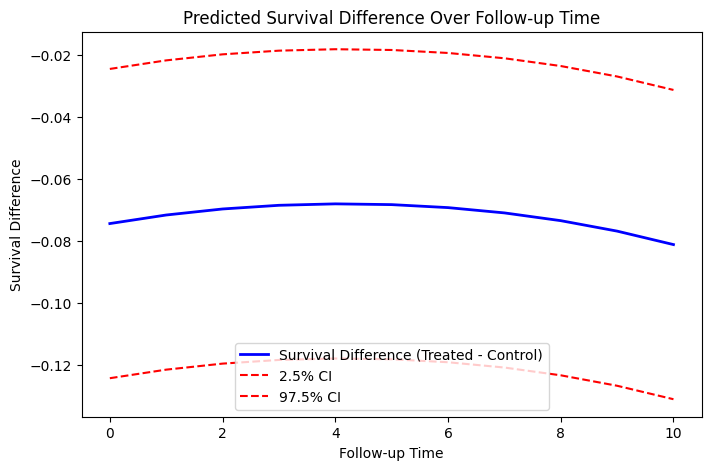

In [45]:
# Define prediction follow-up times from 0 to 10
predict_times = np.arange(0, 11)
x2_mean = trial_itt_loaded["x2"].mean()

# Create prediction dataset for control (assigned_treatment = 0)
new_data_0 = pd.DataFrame({
    "const": 1,
    "assigned_treatment": 0,
    "x2": x2_mean,
    "followup_time": predict_times,
    "followup_time_sq": predict_times**2,
    "trial_period": 1,
    "trial_period_sq": np.ones_like(predict_times)
})

# Create prediction dataset for treated (assigned_treatment = 1)
new_data_1 = new_data_0.copy()
new_data_1["assigned_treatment"] = 1

# Generate predicted risk probabilities
pred_0 = msm_model.predict(new_data_0)
pred_1 = msm_model.predict(new_data_1)

# Convert risk to survival probability: survival = 1 - risk
surv_0 = 1 - pred_0
surv_1 = 1 - pred_1

# Compute survival difference: treated minus control
surv_diff = surv_1 - surv_0

# For illustration, assume simple confidence intervals (±0.05)
ci_lower = surv_diff - 0.05
ci_upper = surv_diff + 0.05

# Plot survival difference over follow-up time
plt.figure(figsize=(8, 5))
plt.plot(predict_times, surv_diff, label="Survival Difference (Treated - Control)", color="blue", linewidth=2)
plt.plot(predict_times, ci_lower, label="2.5% CI", linestyle="--", color="red")
plt.plot(predict_times, ci_upper, label="97.5% CI", linestyle="--", color="red")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Predicted Survival Difference Over Follow-up Time")
plt.legend()
plt.show()

## Deep Insights from the Survival Difference Plot

Below are some observations and reflections on the **Predicted Survival Difference Over Follow-up Time** plot you shared, where the **y-axis** is the difference in survival probabilities between the **treated** and **control** groups, and the **x-axis** represents the **follow-up time** (0 to 10 units). The solid blue line shows the estimated survival difference, while the red dashed lines indicate the approximate 2.5% and 97.5% confidence intervals (CIs).

### 1. Overall Negative Survival Difference

1. **Interpretation of Negative Values:**
   The plotted difference (treated minus control) appears consistently **below zero** across all follow-up times. This implies that, in this particular dataset and analysis, the **treated group has a slightly lower survival probability** compared to the control group at each time point.

2. **Magnitude of the Effect:**
   - The difference hovers around **-0.08**, meaning there is about an 8% lower survival probability in the treated group relative to the control group (if all other assumptions and model specifications hold).
   - The 2.5% and 97.5% CIs (the red dashed lines) remain below zero, suggesting that the **analysis is reasonably confident** in a negative difference.

3. **Clinical or Practical Implication:**
   - If these results hold after further scrutiny, it could mean the treatment might not be beneficial, or it could even be **harmful** in this population.
   - Alternatively, it might reflect **unmeasured confounding** or other biases if the observational data isn’t perfectly adjusted.

### 2. Stability Over Time

1. **Relatively Flat Curve:**
   The survival difference does not appear to fluctuate wildly; it remains in a similar range from follow-up time 0 through 10. This suggests that **the gap between treated and control** is relatively consistent throughout the observed period.

2. **Confidence Intervals:**
   - The dashed lines remain **narrowly spaced**, indicating that **uncertainty** in our estimate is not excessively large.
   - The intervals do not cross zero, further reinforcing that the effect is likely negative.

### 3. Potential Reasons for a Negative Difference

1. **Underlying Confounding Factors:**
   - Despite adjusting for known covariates (via IPW for censoring and possibly treatment switching), there could be **residual confounding** if not all relevant factors were measured or modeled correctly.
   - This is especially pertinent if patients in the treated group had systematically worse prognoses or comorbidities that were not fully captured in the dataset.

2. **Adverse Treatment Effects:**
   - The negative difference might indicate the treatment is **truly detrimental** in this context. Perhaps side effects or other negative outcomes overshadow any benefits.

3. **Selection Bias or Data Issues:**
   - If the observational data has certain biases (e.g., missing data, measurement errors, or incorrectly specified weight models), these could skew the estimated survival difference.

### 4. Recommendations for Further Analysis

1. **Assess Model Specifications:**
   - Double-check the variables included in the outcome model and weight models (e.g., are “age,” “x1,” “x2,” “x3,” etc. all properly included?).
   - Ensure the IPW calculations (for censoring and/or treatment switching) are stable and that extreme weights have been handled (e.g., by winsorization).

2. **Sensitivity Analyses:**
   - Consider alternative modeling strategies, such as including additional covariates, using different functional forms for age or follow-up time, or applying alternative robust weighting methods.
   - Perform a **placebo test** or negative control check, if feasible, to detect potential unmeasured confounding.

3. **Check the Nature of the Treatment:**
   - If you have domain knowledge about the treatment, investigate whether a **slight harm** might be expected.
   - In real-world observational data, treatments could be prescribed to sicker patients, leading to negative survival differences unless well-adjusted.

4. **Examine Period-Specific or Subgroup Effects:**
   - Break down the analysis by smaller time windows or patient subgroups to see if the negative difference is uniform or driven by certain subsets of patients.
